In [1]:
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# !pip install scikit-image
from skimage.measure import compare_ssim

In [1]:
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# ! pip install fastcluster
from fastclustering import FastAgglomerativeClustering
# Ускоренна агломеративная кластеризация FastAgglomerativeClustering
# инициализация FastAgglomerativeClustering(n_clusters=n)
# метод обучения fit(X)
# получить предсказания можно с помощью атрибута labels

## Цветовая квантизация изображения с помощью кластеризации 
Вам предлагается решить следующую задачу: с помощью методов кластеризации уменьшить количество цветов изображения так, чтобы новое изображение было максимально визуально похоже на исходное. Эта задача без ограничения на метод решения носит название [цветовой квантизации изображения](https://en.wikipedia.org/wiki/Color_quantization). Это может быть применимо, например, для сжатия изображения.

*Данные*  
Изображение представляет собой массив размера $(H \times W \times 3)$, где $H$ и $W$ &mdash; соответственно высота из ширина изображения в пикселях, $3$ &mdash; размерность пикселя. Пиксели несут в себе информации о цвете и представляют собой трехмерные векторы в пространстве RGB (Red, Green, Blue). Первое число соответствует красному цвету, второе &mdash; зеленому, третье &mdash; синему. Каждое число принимает целое значение в отрезке от $0$ до $255$.  
В качестве примера изображения предлагается использовать файл 'pesik.png'.

Размерность массива изображения (200, 300, 3)


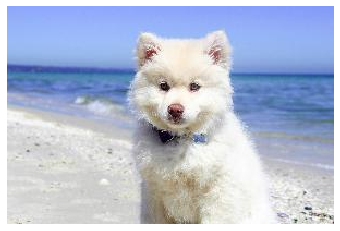

In [4]:
# Представление изображения в виде массива
img = plt.imread('pesik.jpg')
print("Размерность массива изображения", img.shape)

# Визуализация массива
plt.imshow(img)
plt.axis('off');

*Идея решения*  
Идея применения кластеризации в качестве метода решения задачи заключается в следующем. С одной точки зрения пиксели &mdash; это точки изображения имеющие пространственные координаты, содержащие информацию о цвете. А если посмотреть с другой стороны, то &mdash; это точки имеющие цветовые координаты, несущие информацию о местоположеннии в изображении. Следуя второй точке зрения, предположим, что пиксели разбиваются на $n$ кластеров в цветовом пространстве. Тогда пиксели лежащие в одном кластере будут ближе друг к другу по цвету, чем к другим пикселям. Таким образом, присвоив всем пикселям в одном кластере цвет, который наилучшим образом описывает кластер, можно получить изображение из n цветов достаточно визуально близкое к исходному.  

*Задание*

1. Визуализация данных 
   
    Визуализируете объекты в прострастве RGB в формате 2D (без использования методов понижения размерности).

In [5]:
# Избавление от первых 2 размерностей
X = np.vstack(img)
X.shape

(60000, 3)

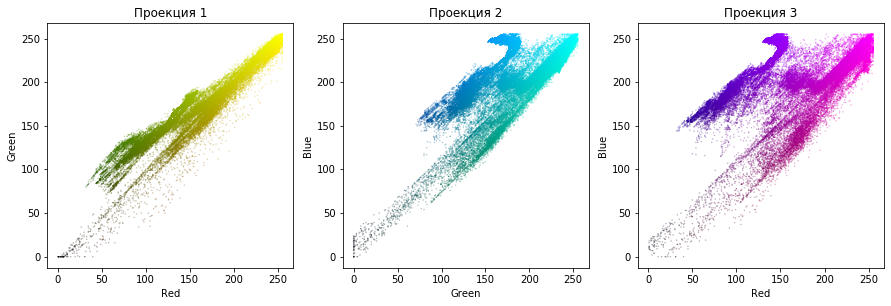

In [6]:
# Визуализация
names = ['Red', 'Green', 'Blue']
plt.figure(figsize=(15, 4.5))
for i, (c1, c2) in enumerate(zip([0, 1, 0], [1, 2, 2])):
    axs = plt.subplot(1, 3, i+1)
    colors = np.zeros((3, X.shape[0]))
    colors[c1] = X[:, c1] / 255
    colors[c2] = X[:, c2] / 255
    plt.scatter(X[:, c1], X[:, c2], alpha=0.5, c=colors.T, s=0.1)
    plt.xlabel(names[c1])
    plt.ylabel(names[c2])
    plt.title('Проекция {}'.format(i+1))

* Видны ли кластеры? Сколько кластеров вы бы выделили?

Наблюдается 3-4 кластера.

    Вспомните методы понижения размерности. Какие на ваш взгляд наиболее эффективные для визуализации кластеров в данных?  Требуют ли эти методы нормировку? Какой из этих методов работает быстрее? 

1. Среди методов понижения размерности наиболее эффективными для визуализации кластеров являются TSNE и UMAP. Они используют нелинейные преобразования и максимально сохраняют структуру данных.
2. TSNE и UMAP используют расстояние между точками. Поэтому данные нужно нормировать.
3. В силу архитетурв методов UMAP работает быстрее на больших данных.

Выберите метод понижения размерности. Примените его к данным, понизив размерность до 2.

Исходя из достоинтсв UMAP, перечисленных выше, будем использовать это метод.

In [9]:
X_umap = UMAP(n_components=2, n_neighbors=20).fit_transform(X)

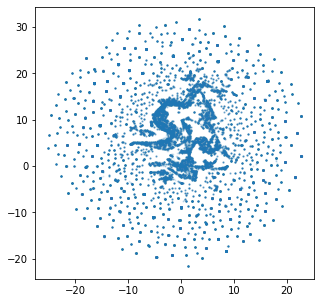

In [10]:
plt.figure(figsize=(5, 5))
plt.scatter(X_umap.T[0], X_umap.T[1], s=1, alpha=0.1)

    Видны ли кластеры? Сколько кластеров вы бы выделили?

2. Применение кластеризации  
  
    Вспомните методы кластеризации, которые могут разбивать данные на заданное число кластеров. Какова сложность этих методов? Требют ли эти методы нормировки данных?

Перечислим методы кластеризации, которые могут разбивать данные на заданное число кластеров. Также запишем время работы методов в зависимости от $n$ &mdash; числа элементов в выборке, и определим, нужна ли нормировка.
* K-средних -- $O(n)$, нормировка нужна.
* Гауссовская смесь -- $O(n)$, нормировка не нужна.
* Спектральная кластеризация -- $O(n^3)$, нормировка нужна.
* Аггломеративная кластеризация в общем случае -- $O(n^3)$, нормировка нужна.
* Аггломеративная кластеризация, вычиленная специальным образом -- $O(n^2)$, нормировка нужна.   


    Выберите 3 метода на ваш вкус. Разбейте данные на 8 кластеров с использованием этих методов. Отобразите результаты в виде изображений и сравните с исходным изображением.

Выберем наиболее быстрые методы: к-средних, гауссовскую смесь и ускоренную агломеративную кластреизацию.

In [17]:
n = 8
img_new = np.zeros((3, *img.shape), dtype=int)
labels = np.zeros((3, X.shape[0]), dtype=int)

In [18]:
# K-Means
k_means = KMeans(n_clusters=n)
k_means.fit(X)
labels[0] = k_means.labels_
values = k_means.cluster_centers_.squeeze().astype(int)
img_new[0] = np.array([values[labels[0][i]] for i in range(X.shape[0])])\
    .reshape(img.shape)

In [19]:
# Gaussian Mixture
gauss_mix = GaussianMixture(n_components=n)
gauss_mix.fit(X)
labels[1] = gauss_mix.predict(X)
values = np.array([np.median(X[labels[1] == i], axis=0) for i in range(n)]).astype(int)
img_new[1] = np.array([values[labels[1][i]] for i in range(X.shape[0])])\
    .reshape(img.shape)

In [20]:
# Fast Agglomerative Clustering
agglomerat = FastAgglomerativeClustering(n_clusters=n)
agglomerat.fit(X)
values = agglomerat.predict().astype(int)
labels[2] = agglomerat.labels.astype(int)
img_new[2] = values.reshape(img.shape)

Изобразите результаты кластеризации используя выбранный метод понижения размерности.

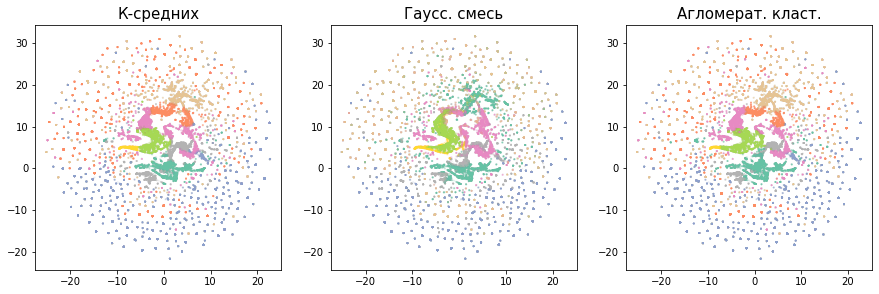

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))
methods_names = ['К-средних', 'Гаусс. смесь',  'Агломерат. класт.']
labels_new = np.zeros_like(labels)
labels_new[0] = labels[0]
for i in range(n):
    mask0 = labels[0] == i
    label1 = np.median(labels[1][mask0])
    mask1 = labels[1] == label1
    labels_new[1][mask1] = i
    
    label2 = np.median(labels[2][mask0])
    mask2 = labels[2] == label2
    labels_new[2][mask2] = i
    
for i, method_name in enumerate(methods_names):
    axs[i].scatter(X_umap.T[0], X_umap.T[1], s=1, alpha=0.1, c=labels_new[i], cmap='Set2')
    axs[i].set_title(method_name, fontsize=15)

Text(0.5, 1.0, 'Real')

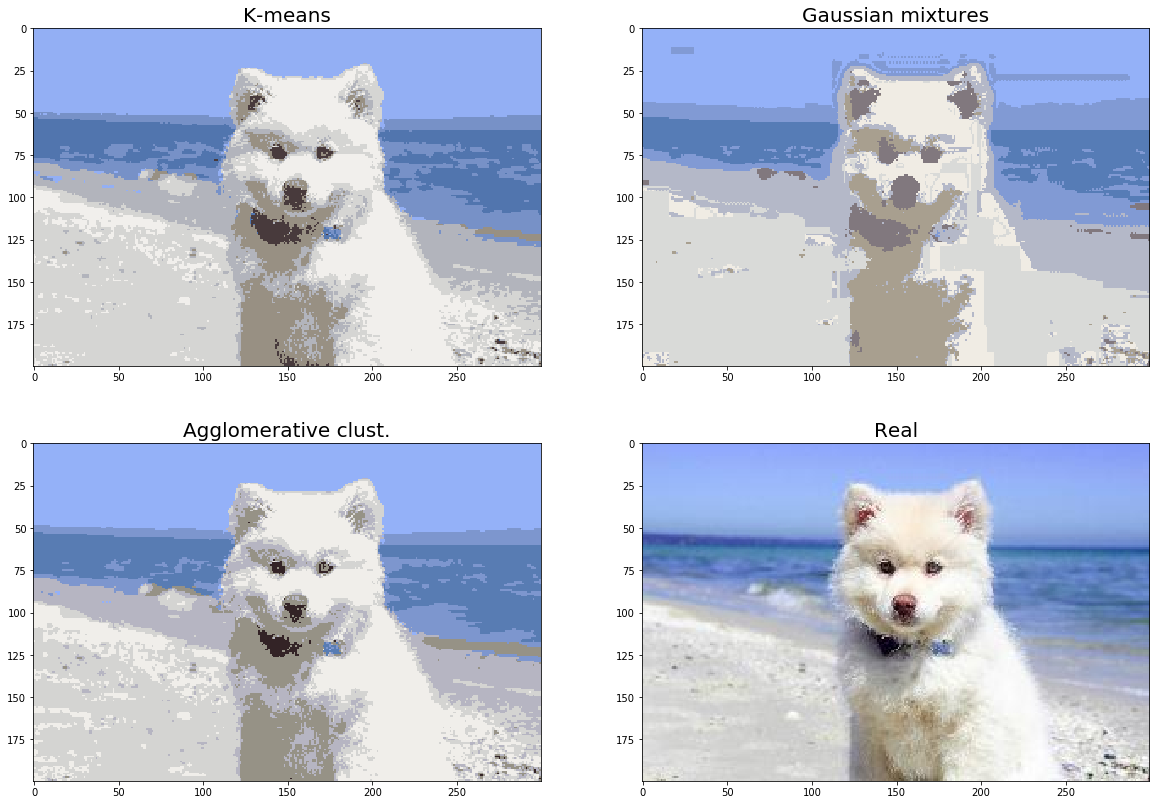

In [94]:
# Визуализация
fig, axs = plt.subplots(2, 2, figsize=(20, 14))
axs[0, 0].imshow(img_new[0])
axs[0, 0].set_title('K-means', fontsize=20)
axs[0, 1].imshow(img_new[1])
axs[0, 1].set_title('Gaussian mixtures', fontsize=20)
axs[1, 0].imshow(img_new[2])
axs[1, 0].set_title('Agglomerative clust.', fontsize=20)
axs[1, 1].imshow(img)
axs[1, 1].set_title('Real', fontsize=20)
plt.axis('off');

*Какой метод показывает лучшие результаты?*

К-средних и агломеративная кластеризация справились одинаково хорошо.

Посчитайте метрику схожести изображений [SSIM](https://ru.wikipedia.org/wiki/SSIM), которая учитывает воспириятие изображения человеком.

In [97]:
# Пример
compare_ssim(img, img, multichannel=True)

1.0

In [108]:
ssim = np.zeros(3)
for i in range(3):
    ssim[0] = compare_ssim(img, img_new[0], multichannel=True)
    ssim[1] = compare_ssim(img, img_new[1], multichannel=True)
    ssim[2] = compare_ssim(img, img_new[2], multichannel=True)
print('К-средних:', ssim[0])
print('Гаусс. смесь', ssim[1])
print('Агломерат. класт.', ssim[2])

К-средних: 0.7837097103732451
Гаусс. смесь 0.6099103431253684
Агломерат. класт. 0.7789707918098389


<BarContainer object of 3 artists>

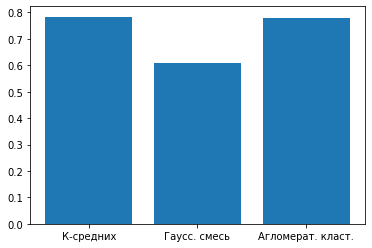

In [106]:
plt.bar(['К-средних', 'Гаусс. смесь',  'Агломерат. класт.'], ssim)

    Какой метод показывает лучшее значение метрики? Сходятся ли результаты с вашим восприятием полученных изображений? 

3. Качество сжатия в зависимости от числа кластеров   
  
    Выберите метод кластеризации и примените его к данным, задавая различное количество кластеров: 2, 4, 8, 16, ... 256.


In [121]:
X.shape[0]

60000

In [128]:
img_new = np.zeros((8, *img.shape), dtype=int)
labels = np.zeros((8, X.shape[0]), dtype=int)
for i in range(8):
    n = int(2 ** (i + 1))
    k_means = KMeans(n_clusters=n)
    k_means.fit(X)
    labels[i] = k_means.labels_
    values = k_means.cluster_centers_.squeeze().astype(int)
    img_new[i] = np.array([values[labels[i][j]] for j in range(X.shape[0])])\
        .reshape(img.shape)

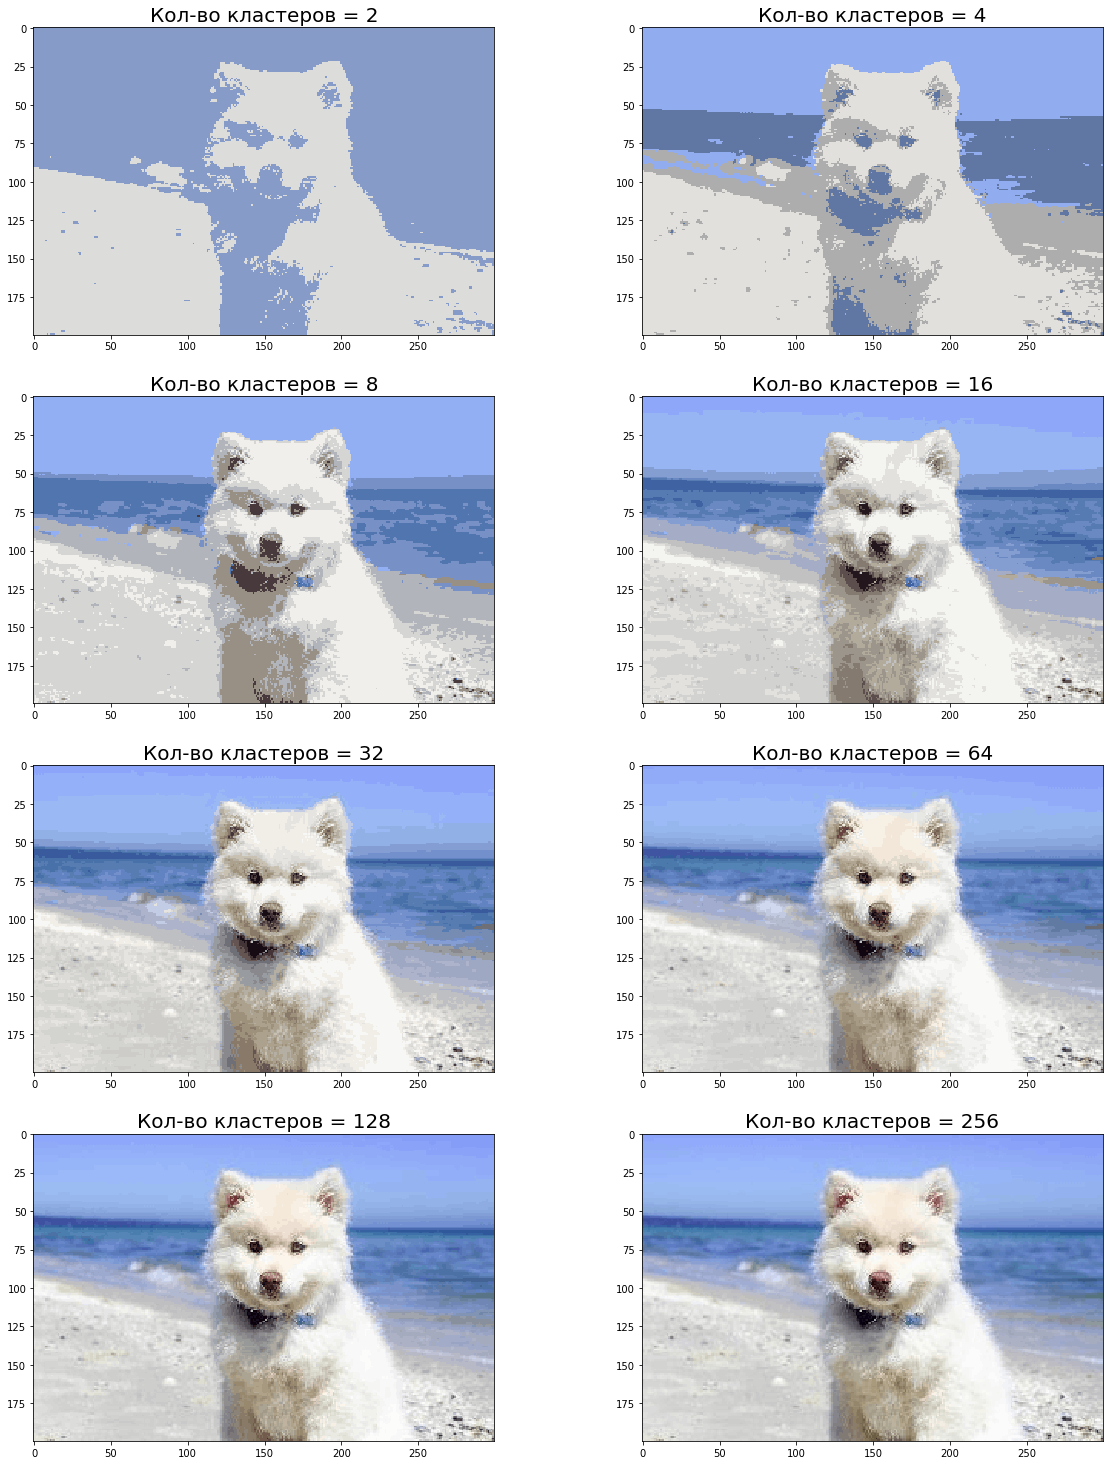

In [112]:
fig, axs = plt.subplots(4, 2, figsize=(20, 26))
for i in range(8):
    n = int(2 ** (i+1))
    axs[i//2, i%2].imshow(img_new[i])
    axs[i//2, i%2].set_title('Кол-во кластеров = {}'.format(n), fontsize=20)

    Постройте график метрики SSIM в зависимости от количества кластеров.

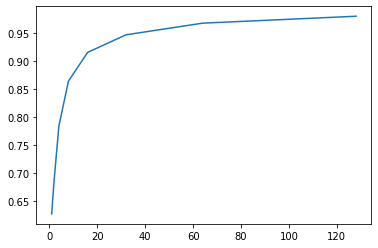

In [114]:
ssim = [compare_ssim(img, img_new[i], multichannel=True) for i in range(8)]  
plt.plot(2 ** np.arange(8), ssim)

    Сделайте вывод

*Ответ*  
Чем больше кластеров, тем лучше метрика, что вполне логично. При этом зависимость практически экспоненциальная. Метрика начинает мало меняться начиная где-то с 16 цветов. То же можно сказать и про полученные изображения. 